### 新潟県行政区域別人口分布（RESASデータ：2015年）
（兼 RESAS API動作確認）
+ `niigata_GML`フォルダを解凍し、dataフォルダにフォルダごとコピー

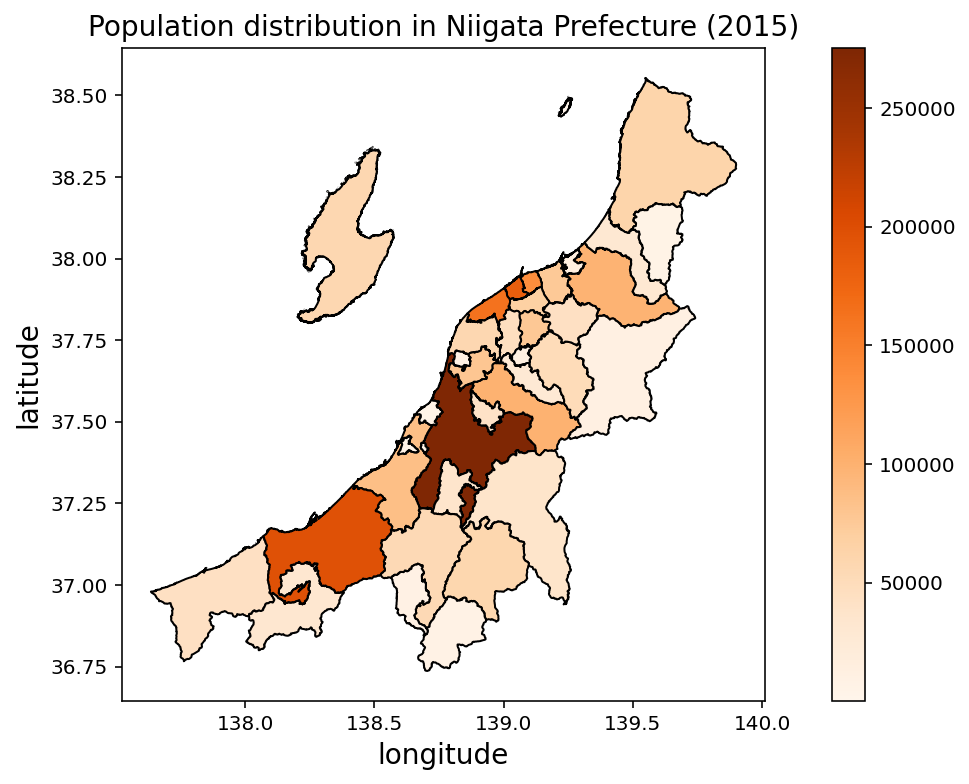

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import json, requests
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# RESAS API

key = 'mVbXzmr8bQW5qWtMhKIm5j3R6jDPQxB2bNdg5mZ4'
baseurl = 'https://opendata.resas-portal.go.jp/'
outType = "&sectionCode=-&dispType=1&matter=1"

def resasAPI(key, url, *, cityCode=""):
    if cityCode != "":
        url.insert(3, "&cityCode=" + str(cityCode))

    url = "".join(url)
    x = json.loads(requests.get(baseurl + url, headers={'X-API-KEY':key}).text)
    dataframe = pd.json_normalize(x['result'])
    return dataframe

def resasAPI_json(key, url, *, cityCode=""):
    if cityCode != "":
        url.insert(3, "&cityCode=" + str(cityCode))

    url = "".join(url)
    x = json.loads(requests.get(baseurl + url, headers={'X-API-KEY':key}).text)
    return x

def seek_year(lst, year):
    out_dict = {}
    for k in lst:
        out_dict[k['year']] =  k['value']
    return out_dict[year]

def get_cityCode(pref):
    # cityCodeリスト生成用のデータフレーム作成
    category = "api/v1/cities"
    param_list = [category, "?prefCode=", str(prefCode), outType]
    df = resasAPI(key, param_list)

    # cityCodeリスト生成（1都道府県内、政令指定都市を除く）
    citycode_list = df.query('bigCityFlag < "2"')['cityCode'].to_numpy()
    return citycode_list

def make_prefdict(key, category, prefCode, year, outType):
    prefpop_dict = {}
    for code in get_cityCode(prefCode):
        url = [category, "?prefCode=", str(prefCode), outType]
        val = resasAPI_json(key, url, cityCode = code)['result']['data'][0]['data']
        val = seek_year(val, year)
        prefpop_dict[code] = val   # add elements in a dictionary
    return prefpop_dict


# 都道府県、年を指定して市区町村（コード）別の指定年の人口を出力
prefCode = 15  # 新潟県
year = 2015
category = "api/v1/population/composition/perYear"

# 新潟県の地理情報データ（地図作製用）
df_geo = gpd.read_file('DSA_data/niigata_GML/N03-19_15_190101.geojson')

# 市区町村別人口データの作成
prefpop_dict = make_prefdict(key, category, prefCode, year, outType)
data = []
for code in df_geo['N03_007']:   # N03_007: 行政区域code
    data.append(prefpop_dict[code])
df_geo['population'] = data

# データの地図上への描画
df_geo.plot(column="population", edgecolor='black', figsize=(12, 6), cmap='Oranges', legend=True)
plt.xlabel('longitude',  fontsize=14)
plt.ylabel('latitude',  fontsize=14)
plt.title(f'Population distribution in Niigata Prefecture ({year})', fontsize=14);